**code for training models**

In [1]:
%load_ext autoreload
%autoreload 2
#required packages
import os
import glob
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import cluster
import pickle
from datetime import datetime
#need to run as administrator, otherwise takes too long
import umap
#my funcs
from ecog_functions import *

#inductive 
from sklearn.base import BaseEstimator, clone
from sklearn.cluster import AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.utils.metaestimators import available_if
from sklearn.utils.validation import check_is_fitted

In [2]:
#paths
FEATURE_PATH = r'C:\Users\marty\Projects\sleep_new\res_temp\*'
#for agglomerative clustering subset
SIZE = 80000
RANDOM_STATE = 42

['C:\\Users\\marty\\Projects\\sleep_new\\res_temp\\11_20232805.pkl',
 'C:\\Users\\marty\\Projects\\sleep_new\\res_temp\\11_20232905.pkl',
 'C:\\Users\\marty\\Projects\\sleep_new\\res_temp\\11_20233005.pkl',
 'C:\\Users\\marty\\Projects\\sleep_new\\res_temp\\11_20233105.pkl',
 'C:\\Users\\marty\\Projects\\sleep_new\\res_temp\\12_20232805.pkl',
 'C:\\Users\\marty\\Projects\\sleep_new\\res_temp\\12_20232905.pkl',
 'C:\\Users\\marty\\Projects\\sleep_new\\res_temp\\12_20233005.pkl',
 'C:\\Users\\marty\\Projects\\sleep_new\\res_temp\\12_20233105.pkl',
 'C:\\Users\\marty\\Projects\\sleep_new\\res_temp\\13_20232805.pkl',
 'C:\\Users\\marty\\Projects\\sleep_new\\res_temp\\13_20232905.pkl',
 'C:\\Users\\marty\\Projects\\sleep_new\\res_temp\\13_20233005.pkl',
 'C:\\Users\\marty\\Projects\\sleep_new\\res_temp\\13_20233105.pkl',
 'C:\\Users\\marty\\Projects\\sleep_new\\res_temp\\14_20232805.pkl',
 'C:\\Users\\marty\\Projects\\sleep_new\\res_temp\\14_20232905.pkl',
 'C:\\Users\\marty\\Projects\\slee

In [ ]:
#-3 because I have some random files there
feat_paths=glob.glob(FEATURE_PATH)[:-3]
feat_paths

In [3]:
#read selected features
final_features=[]
for path in feat_paths:
    final_features.append(pickle.load(open(path,'rb')))
final_features=pd.concat(final_features)

In [41]:
#savepath for umap
umap_path='./models/umap_'+datetime.now().strftime('%Y%m%d%H%M%S')+'_5rat4day.pkl'
umap_path

'./models/umap_20231215162852_5rat4day.pkl'

In [42]:
#fitting and saving umap
reducer=umap.UMAP(n_components=2, n_neighbors=50, min_dist=0, random_state=RANDOM_STATE)
embedding=reducer.fit_transform(final_features.values)
pickle.dump(reducer, open(umap_path,'wb'))

c:\ProgramData\Anaconda3\envs\basicdata\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


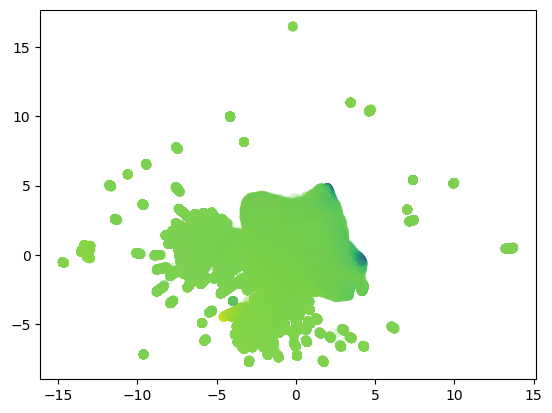

In [5]:
#visualize umap
plt.scatter(embedding[:,0],embedding[:,1], c=final_features['emg_pow'], alpha=0.1)

In [ ]:
#3D UMAP doesn't seem too different - tried
#hard to interpret
#there is no way to check how much data was used in umap

In [113]:
#agglomerative clustering model path
agg_path='./models/agg_'+datetime.now().strftime('%Y%m%d%H%M%S')+'_5rat4day30cl.pkl'
agg_path

'./models/agg_20231219103602_5rat4day30cl.pkl'

In [114]:
#select a random subset for agglomerative clustering
idx = np.random.randint(len(embedding), size=SIZE)
subset_embedding=embedding[idx]

In [ ]:
#data
X = subset_embedding

#Agglomerative clustering preserves small clusters and creates big clusters - tried different methods
#also tried clustering before UMAP, doesn't seem to work well
#fitting model and saving

# Train a clustering algorithm on the training data and get the cluster labels
clusterer = AgglomerativeClustering(n_clusters=30, linkage='ward')
cluster_labels = clusterer.fit_predict(X)
pickle.dump(clusterer, open(agg_path, 'wb'))



# inductive learning model to replicate agglomerative clustering on new data - way more efficient
classifier = RandomForestClassifier(random_state=RANDOM_STATE)
inductive_learner = InductiveClusterer(clusterer, classifier).fit(X)

#save inductive learner
ind_learner_path = './models/ind_'+datetime.now().strftime('%Y%m%d%H%M%S')+'_5rat4day30cl.pkl'
pickle.dump(inductive_learner, open(ind_learner_path, 'wb'))

In [7]:
#get predictions from loaded inductive learner
inductive_learner=pickle.load(open(r'./models/ind_20231219115111_5rat4day30cl.pkl', 'rb'))

In [8]:
#predictions from inductive clusterer
final_features['cluster']=inductive_learner.predict(embedding)

c:\ProgramData\Anaconda3\envs\basicdata\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\ProgramData\Anaconda3\envs\basicdata\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


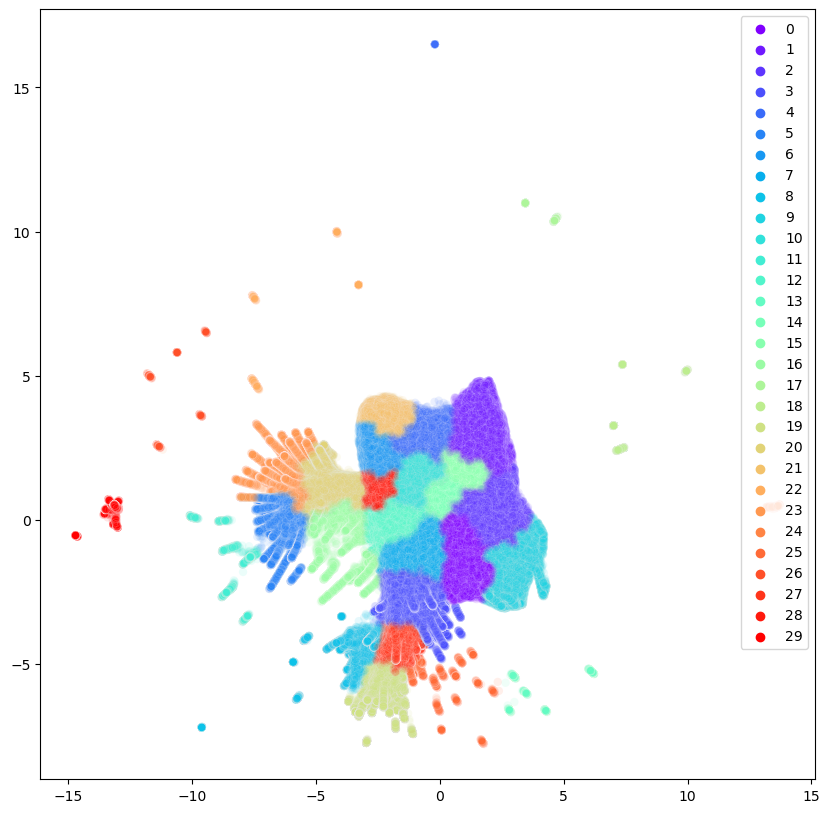

In [9]:
plt.subplots(figsize=(10,10))
sns.scatterplot(x=embedding[:,0],y=embedding[:,1],hue=final_features['cluster'], alpha=0.1, palette='rainbow', legend='full')
plt.legend()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]


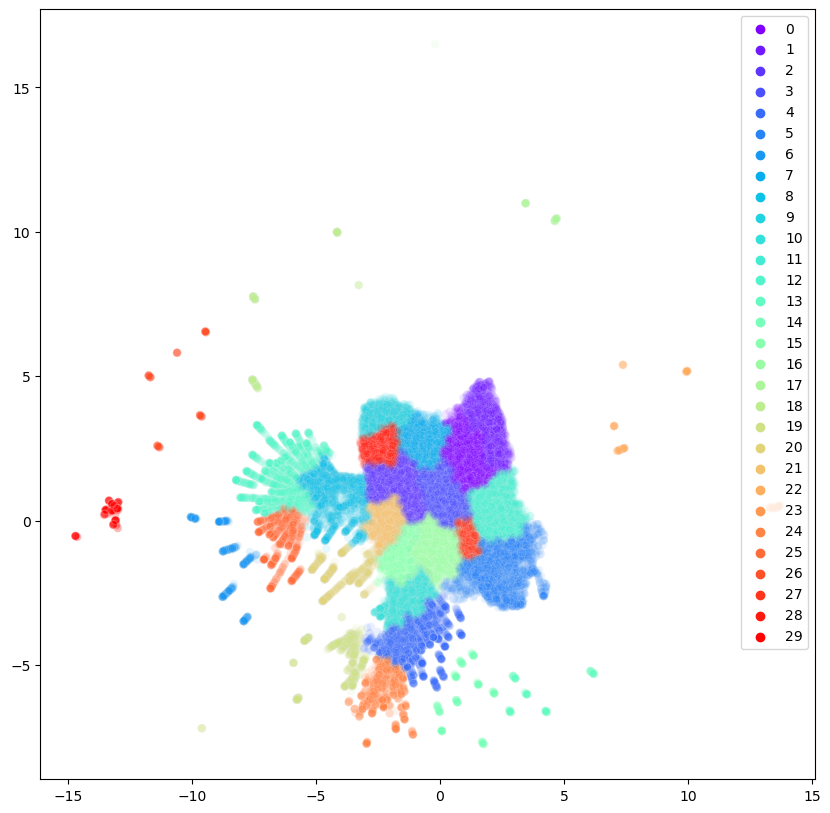

In [193]:
#clusters from agglomerative clustering
plt.subplots(figsize=(10,10))
sns.scatterplot(x=subset_embedding[:,0],y=subset_embedding[:,1],hue=cluster_labels, alpha=0.1, palette='rainbow', legend='full')
plt.legend()